In [1]:
import pandas as pd
import numpy as np
import qpm

In [2]:
df_ETF_raw = pd.read_parquet('../../Data/ETFData.parquet')

In [3]:
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == 'SPY']

# Select the relevant variables for our strategy
df_ETF = df_ETF[['date', 'ym', 'retd', 'retM', 'mktrf', 'rf']]

# Sort the data
df_ETF.sort_values(['date'], inplace = True)

In [4]:
df = df_ETF.groupby('ym').agg({
    'retd': 'std',
    'retM': 'first',
    'rf': 'first',
    'mktrf': 'first'
})
df = df.rename(columns={'retd': 'sd'})
df

,sd,retM,rf,mktrf
ym,,,,
2003-01-01,0.014982,-0.024595,0.0010,-0.0257
2003-02-01,0.011635,-0.013479,0.0009,-0.0188
2003-03-01,0.016972,0.002289,0.0010,0.0109
2003-04-01,0.011782,0.084612,0.0010,0.0822
2003-05-01,0.009799,0.054836,0.0009,0.0605
...,...,...,...,...
2023-03-01,0.011428,0.036936,0.0036,0.0251
2023-04-01,0.007591,0.015975,0.0035,0.0061
2023-05-01,0.008056,0.004616,0.0036,0.0035


In [5]:
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)
df['c'] = 1.25 * df['Lsd'].mean()
df['weight'] = np.minimum(df['c'] / df['Lsd'], 2).fillna(1)
df.drop(columns = ['sd','Lsd', 'c'], inplace = True)

In [6]:
df_ret = pd.read_parquet('downside_beta_ret.parquet')

In [7]:
df_merged = df.merge(df_ret[['ldate', 'retP_rank_longonly', 'retP_rank_longshort', 'retF_vw']], left_on=df.index, right_on='ldate', how='left')
df_merged.rename(columns={'ldate':'ym'}, inplace=True)
df_merged.set_index('ym', inplace=True)

In [8]:
# Returns on the volatility timing strategy
df_merged['retP_rank_longonly_'] = df_merged['weight'] * df_merged['retP_rank_longonly'] + (1 - df_merged['weight']) * df_merged['rf']
df_merged['retP_rank_longshort_'] = df_merged['weight'] * df_merged['retP_rank_longshort'] + (1 - df_merged['weight']) * df_merged['rf']
df_merged['retF_vw_'] = df_merged['weight'] * df_merged['retF_vw'] + (1 - df_merged['weight']) * df_merged['rf']

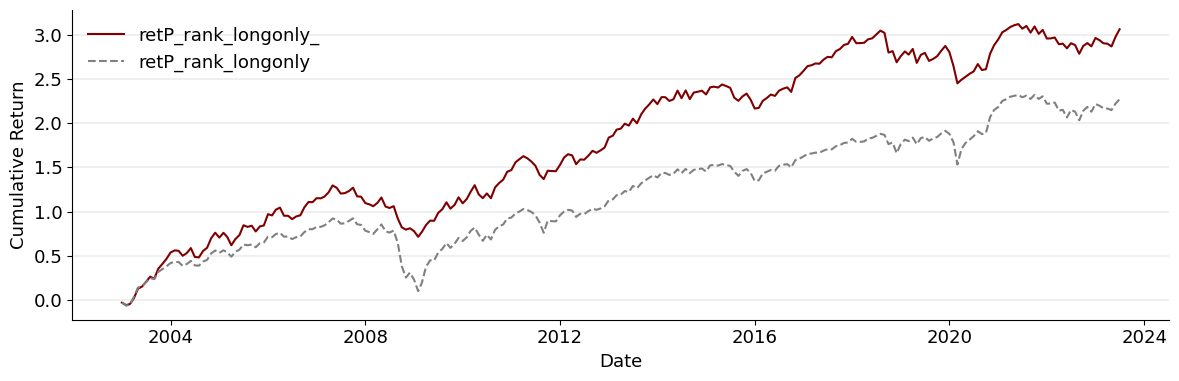

In [9]:
qpm.plot_cumulative_returns_etf(df_merged, var_list =['retP_rank_longonly_', 'retP_rank_longonly'])

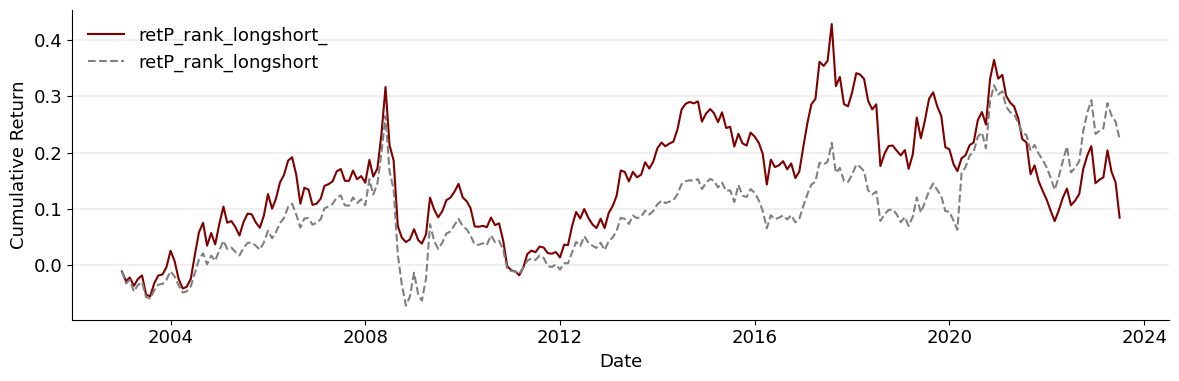

In [10]:
qpm.plot_cumulative_returns_etf(df_merged, var_list =['retP_rank_longshort_', 'retP_rank_longshort'])

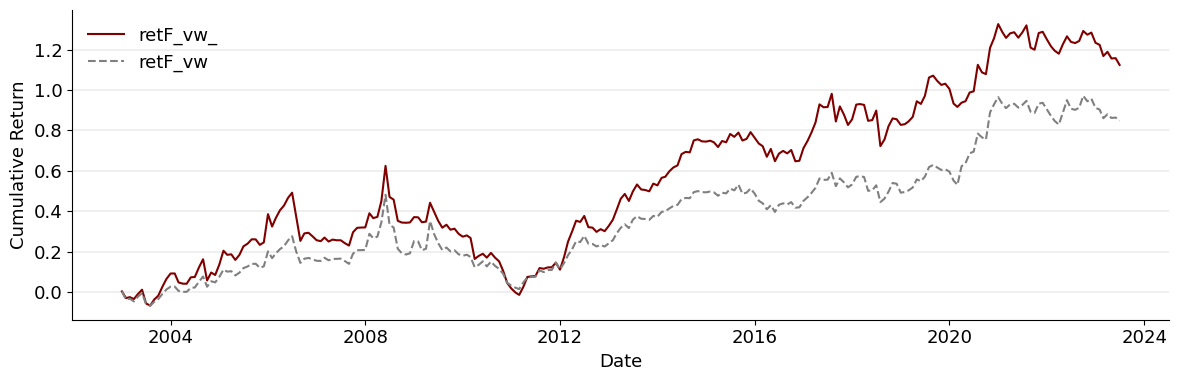

In [11]:
qpm.plot_cumulative_returns_etf(df_merged, var_list =['retF_vw_', 'retF_vw'])

In [12]:
df_analysis = df_merged[['retP_rank_longonly_', 'retP_rank_longshort_', 'retF_vw_']].copy().reset_index()
df_analysis.rename(columns={'retP_rank_longonly_': 'retP_rank_longonly', 'retP_rank_longshort_': 'retP_rank_longshort', 'retF_vw_': 'retF_vw', 'ym': 'ldate'}, inplace=True)
df_analysis

,ldate,retP_rank_longonly,retP_rank_longshort,retF_vw
0,2003-01-01,-0.028889,-0.011710,0.002930
1,2003-02-01,-0.027294,-0.017282,-0.032894
2,2003-03-01,0.010783,0.006606,0.005046
3,2003-04-01,0.067990,-0.014713,-0.009573
4,2003-05-01,0.114391,0.012281,0.025031
...,...,...,...,...
242,2023-03-01,-0.033356,0.004027,-0.053972
243,2023-04-01,-0.005166,0.049382,0.021147
244,2023-05-01,-0.030486,-0.037196,-0.032403
245,2023-06-01,0.116738,-0.019260,0.001533


In [13]:
qpm.analyze_strategy(df_analysis, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                 (1)       (2)      (3)      (4)       (5)       (6)    
------------------------------------------------------------------------
const          0.0056*  0.0031    0.0006   0.0053*  0.0035*   0.0004    
               (0.0030) (0.0022)  (0.0019) (0.0029) (0.0018)  (0.0018)  
mktrf          -0.0020  1.2202*** 0.0152   0.0555   1.0408*** 0.0689    
               (0.0663) (0.0484)  (0.0415) (0.0716) (0.0435)  (0.0444)  
hml                                        -0.1083  -0.0165   -0.0647   
                                           (0.0968) (0.0588)  (0.0600)  
smb                                        -0.2014  0.8036*** -0.2060***
                                           (0.1268) (0.0770)  (0.0786)  
R-squared  